#### Software pipeline to detect vehicles in a video.

Steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images

- Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector.

- Normalize features

- Split training and testing data

- Train a classifier using Linear SVC classifier

- Implement a sliding-window technique and use trained classifier to search for vehicles in images.

- Create heatmap of recurring detections frame by frame and remove false positives by thresholding number of windows found

- Combine multiple boxes into a single one detected for a single car

- Verify pipeline on test images

- Run pipeline on a video stream

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
import os
import time
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from skimage.feature import hog
from p4 import * #project 4: Lane detection

%matplotlib inline


# Step 1: Read cars and non-car images

Number of car images:  8792
Number of non-car images:  8792


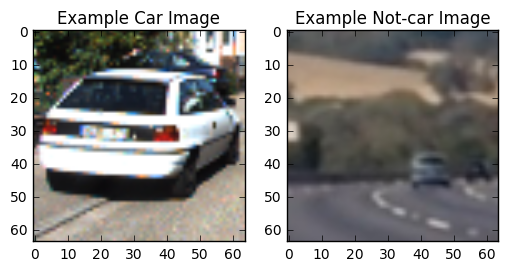

In [7]:
# Read in cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

print ('Number of car images: ', len(cars))
print ('Number of non-car images: ', len(cars))

# Plot examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

## Color histogram - RGB feature vector
Template matching are not robust to changes in appearance, hence we use a better transformation method which is to compute histogram of color values, this gives locations of similar distribution a close match therefore removing sensitiviting to perfect arrangement of pixels.


In [8]:
# Define a function to compute color histogram features  

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0],ghist[0],bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features


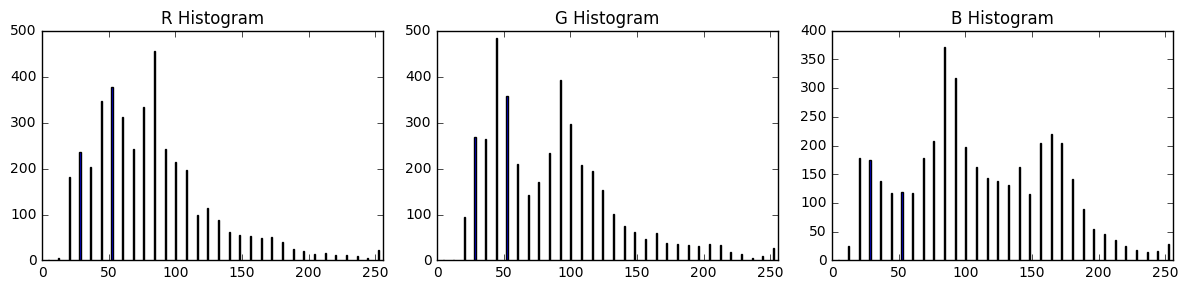

In [9]:
# RGB histogram for car image
test_image = cv2.imread('test_images/car.png')
rh, gh, bh, bincen, feature_vec = color_hist(test_image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    fig.savefig('output_images/color_hist_car.png')
else:
    print('Your function is returning None for at least one variable...')

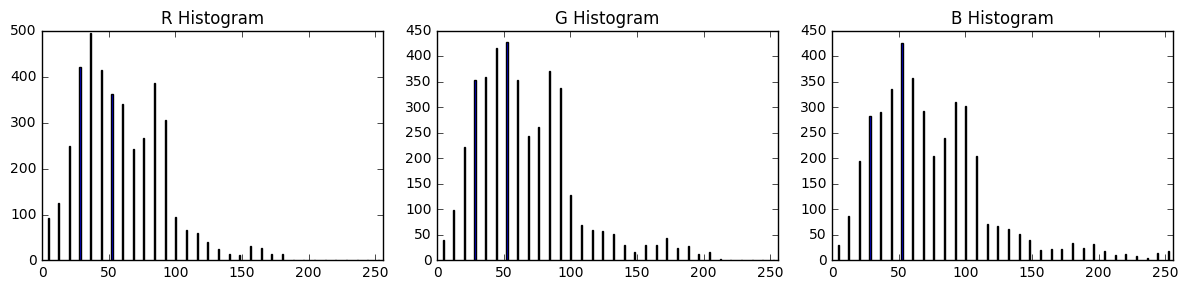

In [10]:
# RGB histogram for non-car image
non_car_image = cv2.imread('test_images/non_car.png')    
rh, gh, bh, bincen, feature_vec = color_hist(non_car_image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    fig.savefig('output_images/color_hist_non_car.png')
else:
    print('Your function is returning None for at least one variable...')

In [11]:
# Helper function to convert color into different color spaces
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [12]:
# Helper function to draw bounding boxes
def draw_boxes(img,boxes,color=(0,0,255),thick=6):
    draw_img=np.copy(img)
    for bbox in boxes:
        cv2.rectangle(draw_img,bbox[0],bbox[1],color,thick)
    return draw_img

## Color spaces - 3D plotting
Cars are more saturated than background like sky, road, etc., hence we will explore different color spaces (RGB, HSV, YCrRB) and also we will check the difference between choosen color space for car image and non car image.

From results of various color spaces we can observe that it is easy to differentiate different colors using YCrRB:

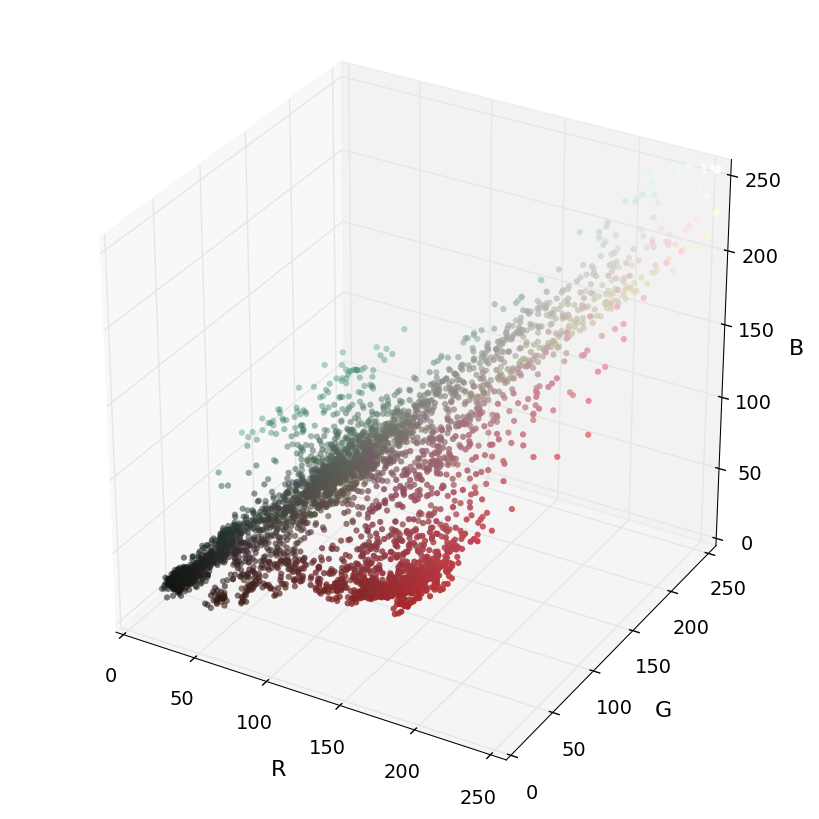

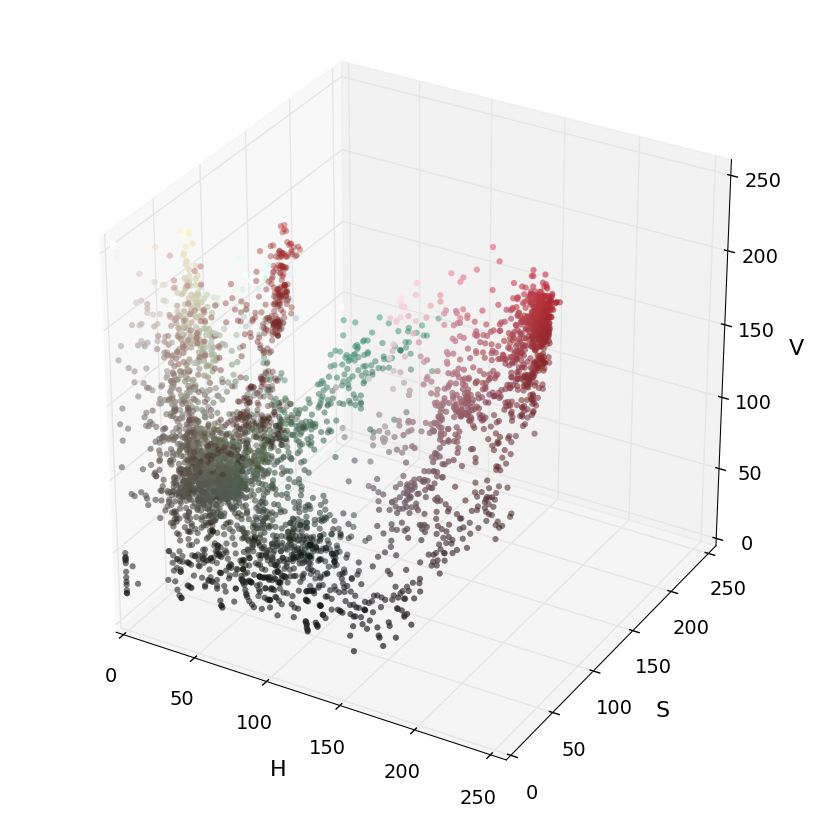

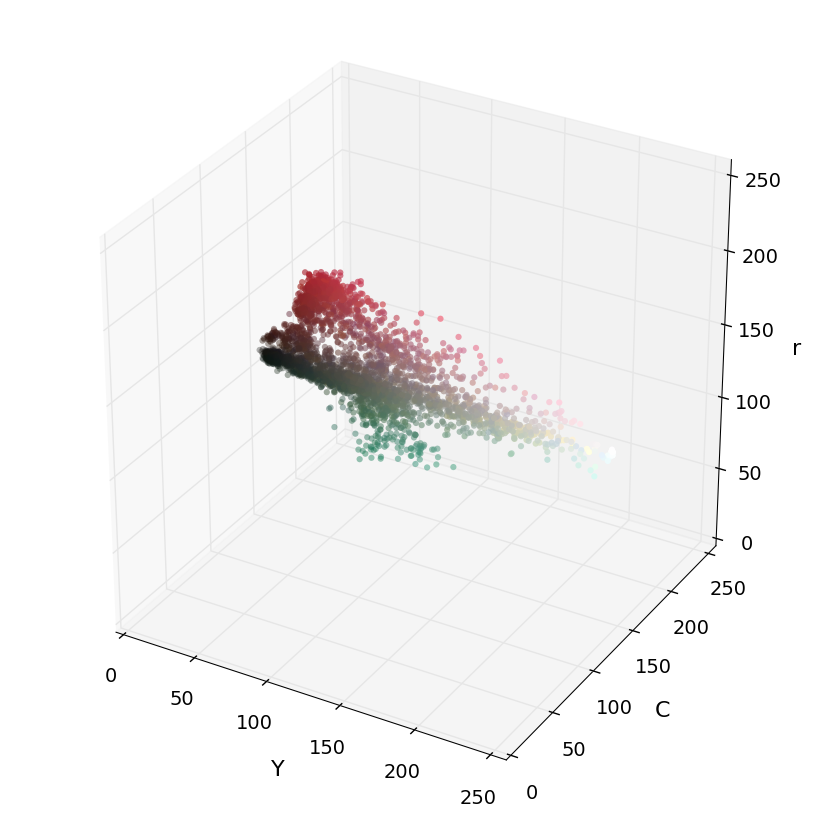

In [13]:
# Plot pixels in 3D
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):


    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

# Read a color image
img = cv2.imread('test_images/car.png')

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_RGB2YCrCb)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

plot3d(img_small_YCrCb, img_small_rgb, axis_labels=list("YCrCb"))
plt.show()


# Spatial Binning of Color:
While it could be cumbersome to include three color channels of a full resolution image, we can perform spatial binning on an image and still retain enough information to help in finding vehicles.

In [14]:
# # Define a function to compute convert color and then perfomr spatial binning
def bin_spatial(img, color_space='HSV', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

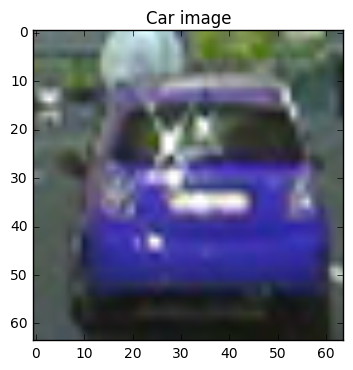

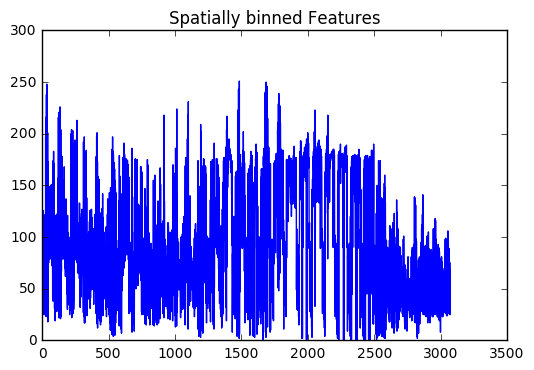

In [15]:
# Test spatial binning
img = cv2.imread('test_images/car.png')
plt.imshow(img)
plt.title('Car image')
plt.show()

feature_vec = bin_spatial(img, color_space='HSV', size=(32, 32))
# Plot features
plt.plot(feature_vec)
plt.title('Spatially binned Features')
plt.show()

# HOG features
In HOG feature descriptor, the distribution (histograms) of directions of gradients (oriented gradients) are used as features.

In [16]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

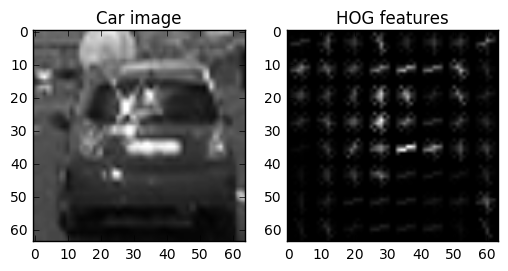

In [17]:
# Extract HOG features to car images

img = cv2.imread('test_images/car.png')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Car image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG features')

# save images
fig.savefig('output_images/hog_features.png')

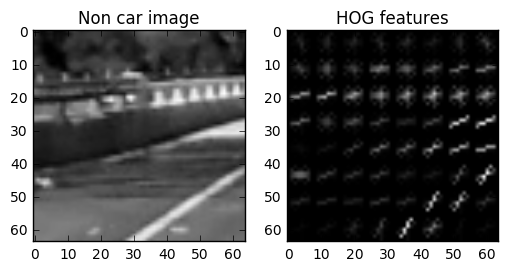

In [18]:
# Extract HOG features to non-car images

img = cv2.imread('test_images/non_car.png')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Non car image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG features')

# save images
fig.savefig('output_images/hog_features.png')

## Combine features
Variety of features helps us in roboust detection system hence we first normalize all these features  using sklearn's functions (see next cell) and then combine them.

In [19]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        combined_features = []
        # Read in each one by one
        image = mpimg.imread(file, format='PNG')
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, conv='RGB2YCrCb')  
        
        if spatial_feat:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            combined_features.append(spatial_features)
        if hist_feat:
            # Apply color_hist() also with a color space option now
            rhist, ghist, bhist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            combined_features.append(hist_features)
        if hog_feat:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                                orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            combined_features.append(hog_features)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate(combined_features))
    # Return list of feature vectors
    return features

### Play around with various parameters

In [20]:
# These parameters can be tweeaked to get best classification with least false positives
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off

In [21]:
# # These parameters can be tweeaked to get best classification with least false positives
# color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 12  # HOG orientations
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
# spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 32    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off

In [22]:
# # These parameters can be tweeaked to get best classification with least false positives
# color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9  # HOG orientations
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
# spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 32    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off

In [23]:
# # These parameters can be tweeaked to get best classification with least false positives
# color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9  # HOG orientations
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = "0" # Can be 0, 1, 2, or "ALL"
# spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 32    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off

In [24]:
# # These parameters can be tweeaked to get best classification with least false positives
# color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9  # HOG orientations
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
# spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 32    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off

## Extract features

In [25]:
t=time.time()
car_features = extract_features(cars, cspace=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat)
notcar_features = extract_features(notcars, cspace=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat)

t2 = time.time()
print ('Color space: ', color_space, '.', 'Hog channel: ', hog_channel)
print(round(t2-t, 2), 'Seconds to extract features...')

Color space:  YCrCb . Hog channel:  ALL
85.16 Seconds to extract features...


## Normalize

In [26]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

## Split test and training data

In [27]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


## Classification begins

In [28]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()

n_predict = 10
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For sample',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
49.53 Seconds to train SVC...
Test Accuracy of SVC =  0.993
SVC predicts:  [ 1.  1.  1.  0.  0.  0.  1.  0.  0.  1.]
For sample 10 labels:  [ 1.  1.  1.  0.  0.  0.  1.  0.  0.  1.]
0.0021 Seconds to predict 10 labels with SVC


# Save parameters

In [29]:
# Save all features to use it in future
import pickle
hist_range = (0, 256)
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["color_space"] = color_space
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["hog_channel"] = hog_channel
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
dist_pickle["hist_range"] = hist_range

with open('svc_pickle.p', 'wb') as f:
    pickle.dump(dist_pickle, f)

# Load parameters

In [30]:
# Read and load all features
dist_pickle = pickle.load(open("svc_pickle.p", "rb"))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
color_space = dist_pickle["color_space"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
hog_channel = dist_pickle["hog_channel"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hist_range = dist_pickle["hist_range"]

# Extract features using hog sub-sampling and make predictions
Instead of extracting hog features for every small patch, we will extract hog features once and sub small to get all windows/boxes.

In [31]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, hist_range):
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    window = 64
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell)-1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog = []
        for channel in range(ctrans_tosearch.shape[2]):
            hog.append(get_hog_features(ctrans_tosearch[:,:,channel], orient, pix_per_cell, cell_per_block, feature_vec=False))
    else:
        hog = get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    img_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(ctrans_tosearch.shape[2]):
                    hog_features.append(hog[channel][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
                hog_features = np.hstack(hog_features)
            else:
                hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            rhist, ghist, bhist, bin_centers, hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))                
                
    return img_boxes


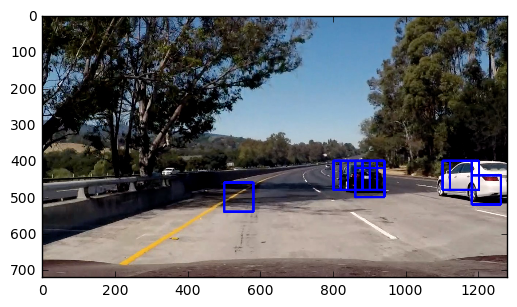

In [32]:
# Test on a sample image with scale=1.25
ystart = 400
ystop = 700
scale = 1.25
window= 64
car_image = mpimg.imread('test_images/test5.jpg')
original_image = mpimg.imread('test_images/test5.jpg')
img_boxes = find_cars(car_image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, hist_range)
window_image = draw_boxes(car_image, img_boxes)
plt.imshow(window_image)

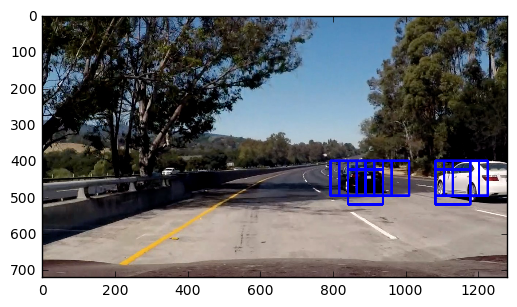

In [33]:
# Test on a sample image but change the scale to 1.5 and see how false postive gets remove 
ystart = 400
ystop = 700
scale = 1.5
window= 64
car_image = mpimg.imread('test_images/test5.jpg')
original_image = mpimg.imread('test_images/test5.jpg')
img_boxes = find_cars(car_image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, hist_range)
window_image = draw_boxes(car_image, img_boxes)
plt.imshow(window_image)

# Multiple Detections
The multi-scale window approach prevents calculation of feature vectors for the complete image and thus helps in speeding up the process.



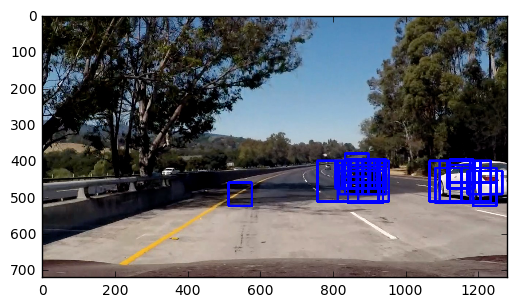

In [34]:
# Now perform multiple detections using different y values and scales
img_boxes = []
for (ystart, ystop, scale) in [(380, 580, 1), (400, 500, 1.2) , (420, 600, 1.5), (400, 650, 1.75), (450, 700, 2.1)]:
#for scale in scales:
    img_boxes += find_cars(car_image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, hist_range)
multiscale_image = draw_boxes(car_image, img_boxes)
plt.imshow(multiscale_image)

# Heat map and false Positives
As seen above we will get multiple detections for the same car and also a false positives (i.e., classifier predicted a car where was no car), we should filter these out.

3 cars found


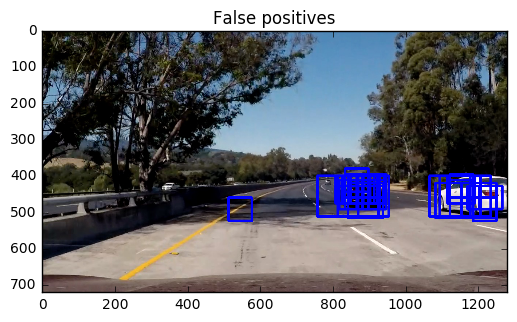

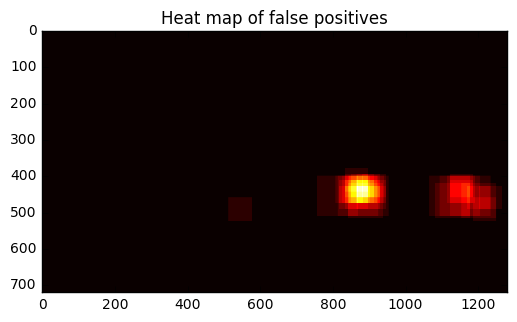

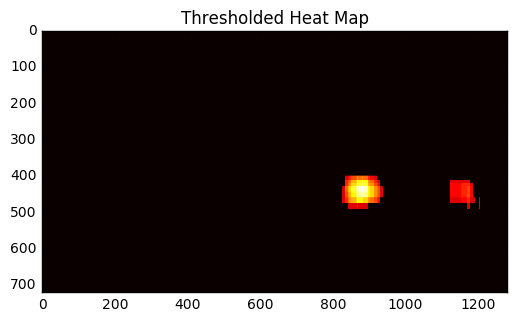

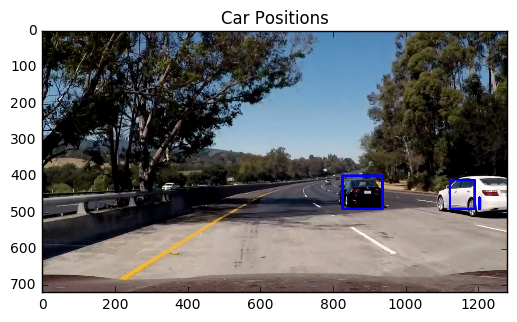

In [35]:
# To make a heat-map, we're simply going to add "heat" (+=1) 
# for all pixels within windows where a positive detection is reported by your classifier.
def add_heat(img, bbox_list):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return np.clip(heatmap, 0, 255)

# Due to above, areas of multiple detections get "hot", while transient false positives stay "cool". 
# We can then simply threshold your heatmap to remove false positives. 
def apply_threshold(heatmap, threshold):
    heat = np.copy(heatmap)
    # Zero out pixels below the threshold
    heat[heat <= threshold] = 0
    # Return thresholded map
    return heat

# We can take our thresholded and labeled images and put bounding boxes around the labeled regions, 
# so that we get single box instead of multiple detections for the same car.
def draw_labeled_bboxes(img, labels):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return imcopy

# Add heat to each box in box list
heatmap = add_heat(car_image, img_boxes)

# Apply threshold to help remove false positives
updated_heatmap = apply_threshold(heatmap, 5)

# Note: To figure out how many cars we have in each frame and which pixels belong to which cars, 
# we use the label() function from scipy.ndimage.measurements.

# Find final boxes from heatmap using label function
labels = label(updated_heatmap)
print(labels[1], 'cars found')
draw_img = draw_labeled_bboxes(np.copy(car_image), labels)

plt.imshow(multiscale_image)
plt.title('False positives')
plt.show()

plt.imshow(heatmap, cmap='hot')
plt.title('Heat map of false positives')
plt.show()

plt.imshow(updated_heatmap, cmap='hot')
plt.title('Thresholded Heat Map')
plt.show()

plt.imshow(draw_img)
plt.title('Car Positions')


### Final pipeline


In [36]:
def pipeline_vechile_detection(img):
    scales = [1., 1.25, 1.5, 1.75, 2.]
    box_list = []
    # Experiment with ystart, ystop and scale values
    
    #for (ystart, ystop, scale) in [(380, 480, 1), (380, 500, 1.3), (450, 600, 1.7), (500, 700, 2.3)]:
    #for (ystart, ystop, scale) in [(380, 580, 1.2), (380, 500, 1.5), (400, 600, 1.75), (410, 700, 2.1)]:
    #for (ystart, ystop, scale) in [(380, 580, 1), (380, 500, 1.3), (380, 590, 1.4) , (400, 580, 1.5), (400, 600, 1.75), (410, 690, 2.3)]:
    #for (ystart, ystop, scale) in [(380, 580, 1), (400, 500, 1.3) , (420, 600, 1.5), (400, 650, 1.7), (450, 680, 2)]:
    for (ystart, ystop, scale) in [(380, 580, 1.2), (380, 500, 1.5), (400, 600, 1.75), (410, 700, 2.1)]:
        heatmap = add_heat(img, box_list)
        updated_heatmap = apply_threshold(heatmap, 5)
        labels = label(updated_heatmap)
        result = draw_labeled_bboxes(img, labels)
    return result

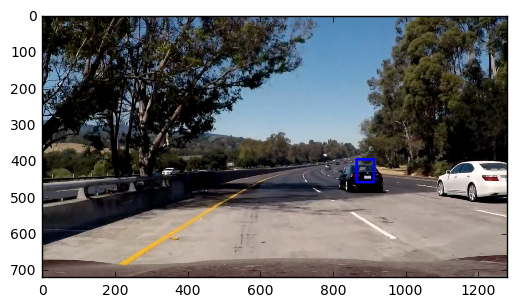

In [37]:
# Test pipeline on series of images

test_images = glob.glob('test_images/*.jpg')
for idx, file in enumerate(test_images):
    img = mpimg.imread(file)
    result = pipeline_vechile_detection(img)
    plt.imshow(result)

# Video Pipeline

In [39]:
# Load the video, call image pipeline and save output

project_output_file_name = 'project_video_output_final.mp4'#output video file name
#clip = VideoFileClip("recorded.mp4") #recorded video on Indian road
clip = VideoFileClip("project_video.mp4") #input test video file

# fl_image: Modifies the images of a clip by replacing the frame by another frame
output = clip.fl_image(pipeline_vechile_detection) #call the pipeline 

%time output.write_videofile(project_output_file_name, audio=False) # save the video

In [40]:
# View video inline
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output_file_name))

## For recorded video on Indian road


In [ ]:
# Load the video, call image pipeline and save output

recorded_output_file_name = 'project_video_output__india_final.mp4'#output video file name
clip = VideoFileClip("recorded.mp4") #recorded video on Indian road

# fl_image: Modifies the images of a clip by replacing the frame by another frame
output = clip.fl_image(pipeline_vechile_detection) #call the pipeline 

%time output.write_videofile(recorded_output_file_name, audio=False) # save the video

[MoviePy] >>>> Building video project_video_output__india_final.mp4
[MoviePy] Writing video project_video_output__india_final.mp4


 37%|███▋      | 293/791 [04:59<08:51,  1.07s/it]

In [ ]:
# View video inline
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(recorded_output_file_name))

## Lane detection and vehicle detection

In [ ]:
# Let us combine project #4 which performs lane detection and this project which detects vehicle

# From project #4:

if __name__ == "__main__":
    # Left and right lane initialization 
    last_left_fit = np.zeros(0)
    last_right_fit = np.zeros(0)
    
    # Load saved camera calibrated file
    calibrated_file = 'calibration.npz'

    # If camera has not been calibrated
    if not os.path.isfile(calibrated_file):
        camera_matrix, dist_coeff = cam_calibrate('./camera_cal/calibration*.jpg')
        np.savez_compressed(calibrated_file, camera_matrix=camera_matrix, dist_coeff=dist_coeff)
    else:
        # Camera has been already calibrated
        data = np.load(calibrated_file)
        cam_matrix = data['camera_matrix']
        dist_coeff = data['dist_coeff']
        
    # Input video
    input_file = VideoFileClip('./project_video.mp4')
    
    # Call your pipeline
    vehicle_detected_clip = clip.fl_image(pipeline_vechile_detection)    
    result = vehicle_detected_clip.fl_image(pipeline)
    
    # Final output
    output_file = './output5.mp4'
    
    # Write the frame to a video file
    result.write_videofile(output_file , audio=False)

    print("Video saved: ", output_file)
        

In [ ]:
# View video inline
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lane_vehicle_detected_output_file))